<a href="https://colab.research.google.com/github/joselvira/BiomecanicaPython/blob/master/Notebooks/Como_cortar_variables_ciclicas_en_sus_repeticiones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cómo cortar variables cíclicas en sus repeticiones

Jose Luis López Elvira ([enlace a más recursos en GitHub](https://github.com/joselvira/BiomecanicaPython))

Última modificación 02/10/2023

Una tarea muy frecuente cuando queremos analizar datos en Biomecánica en movimiento cíclicos, es descomponer la variable continua que representa varias repeticiones del movimiento cíclico en sus distintas repeticiones. Por ejemplo, al analizar la cinemática del pedaleo en ciclismo, si hacemos un registro que incluye 15 pedaladas completas, nos puede interesar cortar cada repetición y colocarlas todas juntas unas sobre otras para analizarlas conjuntamente, algo que se hace comúnmente para tener una representación promedio del movimiento cíclico, lo que en inglés se llama *ensemble average*.

Algunos ejemplos pueden ser variables obtenidas durante el pedaleo de un ciclista (como el ángulo de rodilla), la aceleración durante la carrera obtenida con un acelerómetro colocado en la zona lumbar, o el momento de fuerza medido con un dinamómetro isocinético durante una prueba que implica varias repeticiones dinamicas.

En este notebook veremos cómo gestionar este tipo de situaciones, primero con un ejemplo sencillo de una variable aislada, y después con un ejemplo más realista cuando tenemos datos con distintas condiciones o dimensiones a la vez.

Empezamos importando las librerías típicas para tratar datos que utilizaremos.



In [ ]:
import numpy as np #tipo de datos Numpy
import pandas as pd #tipo de datos Pandas
import matplotlib.pyplot as plt #librería básica para representar gráficas
import seaborn as sns #gráficos avanzados

Para empezar por un ejemplo sencillo, creamos una onda sinusoidal que puede representar a cualquier variable de un movimiento cíclico continuo. Para hacerlo más interesante (y real), haremos que todas las repeticiones no sean exactamente iguales introduciendo algunas diferencias aleatorias.

Por cierto, puedes consultar otro notebook sobre las características de las señales sinusoidales en [Caracteristicas_de_ondas_sinusoidales](https://github.com/joselvira/BiomecanicaPython/blob/master/Notebooks/Caracteristicas_de_ondas_sinusoidales.ipynb).

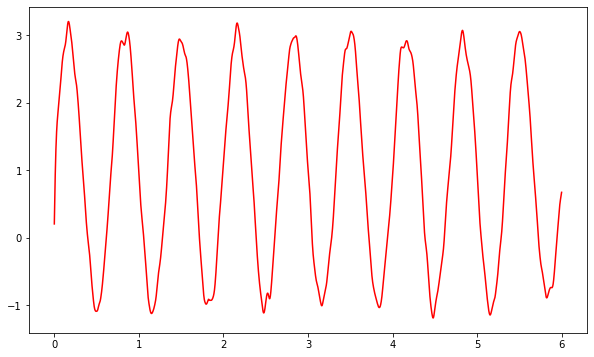

In [ ]:
from scipy.signal import butter, filtfilt

np.random.seed(1234) #fija la aleatoriedad para asegurarse la reproducibilidad

#calcula array tiempo
duracion = 6.0 #duración del registro en segundos 
Fs = 1000 #frecuencia de muestreo en hercios
Ts = 1./Fs #intervalo de tiempo entre datos en segundos
t = np.arange(0, duracion, Ts)


of=-1 #offset vertical
a=2 #ampitud
f=1.5 #frecuencia
af=0 #ángulo de fase, ángulo al inicio del tiempo

señal = np.array(of + a*np.sin(2*np.pi*f*t + af))

#Crea un ruido aleatorio controlado y lo filtra
a_err = a*0.5
pasadas = 2.0 #nº de pasadas del filtro adelante y atrás
orden = 2
fc_err = 10
Cf = (2**(1/pasadas)-1)**(1/(2*orden)) #correction factor. Para 2nd order = 0.802 
Wn = 2*fc_err/Fs/Cf
b1, a1 = butter(orden, Wn, btype = 'low')
ruido = filtfilt(b1, a1, np.random.uniform(a-a_err, a+a_err, len(t)))


#La variable se compone de la suma de señal y ruido, para que tenga un aspecto más aleatorio
var = señal + ruido

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(t, var, '-', color= 'r')
plt.show()


## Buscar los cortes

Para cortar el registro completo, necesitamos un criterio de corte que sirva como inicio de cada repetición. Debe ser un criterio objetivo inequívoco, que esté presente en algún instante de cada ciclo del movimiento. Por ejemplo, en el pedaleo podría ser cuando el pedal derecho se encuentre en la posición más alta, o en la carrera cuando el pie entre en contacto con el suelo, etc.

Dentro de la señal, estos eventos se pueden encontrar cuando la señal supera o pasa por debajo de un umbral, o cuando se produce un máximo o un mínimo local.

En el ejemplo de la señal creada anteriormente, imaginemos que cada ciclo comienza cuando se produce un valor máximo. Tendremos que buscar los instantes en los que se producen esos valores máximos y guardarlos en una variable.

Para señales sencillas, podemos utilizar la función *find_peaks* de la librería *Scipy*, que devuelve los índices de los lugares en los que se producen los máximos locales de la señal.

[ 167  794  867 1479 1825 1843 2162 2523 2857 3510 4108 4167 4827 5503
 5874]


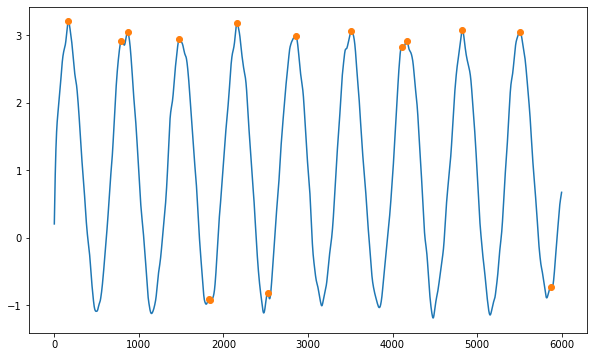

In [ ]:
from scipy.signal import find_peaks

maxs, properties = find_peaks(var)
print(maxs)

#Gráfica con la señal y los puntos máximos encontrados.
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(var)
plt.plot(maxs, var[maxs], 'o')
plt.show()

Fíjate en que en algunas repeticiones encuentra máximos locales muy próximos unos a otros dentro de la misma repetición. Incluso puede encontrar un máximo en un lugar cercano a un valle, porque se produce algún repunte en la señal. Estos problemas son frecuentes en señales reales, por eso la función *find_peaks* tiene algunos parámetros para refinar la búsqueda.

Para poder controlar aún más las opciones de búsqueda, vamos a utilizar otra opción, que es la librería creada por Marcos Duarte que se llama [*Detecta*](https://pypi.org/project/detecta/), que tiene funciones muy flexibles no solo para encontrar los máximos y mínimos locales, sino también para detectar cuándo se supera un umbral, entre otras. Funciona perfectamente para esas tareas.

Para poder utilizar esta librería es necesario instarla. Si estás en google Colab se hace fácilmente con el siguiente comando.

In [9]:
#Instala la librería detecta (Marcos Duarte)
!pip install detecta

from detecta import detect_peaks

Probamos la función con nuestra variable. Fíjate en que tiene incluso una opción para visualizar gráficamente la localización de los eventos que encuentra (activando el parámetro show).

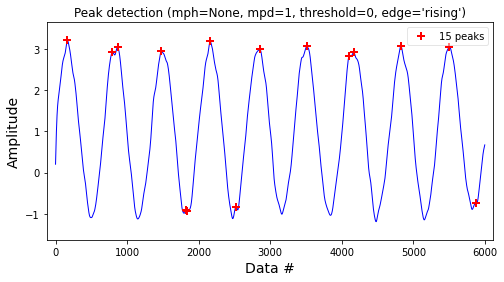

In [ ]:
maxs = detect_peaks(var, show=True)

Para evitar los falsos positivos que se ven en las partes bajas de la gráfica, vamos a perfeccionar la búsqueda introduciendo algunas restricciones. Por ejemplo, cabe esperar que haya un pico cada repetición y no antes, por lo que podemos fijar una distancia mínima de datos desde que encuentra un pico. Podemos utilizar como distancia un número de datos equivalente a la mitad de lo que suele durar una repetición. En este ejemplo la frecuencia de base de la señal son 1.5 Hz, y la frecuencia de registro son 1000 Hz, por lo que cada ciclo o repetición tiene 1000/1.5 datos, es decir, 666.66 datos. Como la duración de cada ciclo no es exacta, pondremos un valor un poco menor para evitar perder máximos.

Con la instrucción help(detect_peaks) se pueden ver todas las opciones que permite la función.

In [ ]:
help(detect_peaks)

Help on function detect_peaks in module detecta.detect_peaks:

detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising', kpsh=False, valley=False, show=False, ax=None, title=True)
    Detect peaks in data based on their amplitude and other features.
    
    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height (if parameter
        `valley` is False) or peaks that are smaller than maximum peak height
         (if parameter `valley` is True).
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a 

Nos interesa modificar el parámetro *mpd*, que regula el mínimo de datos que deben pasar de un pico a otro. Se puede jugar con los valores hasta encontrar una afinación que funcione para lo que queremos hacer. Como vimos anteriormente, en este caso cada ciclo son unos 666 datos, podríamos poner en torno a la mitad de ese valor. En este caso, poniendo mpd=400 funciona bien para evitar los dobles picos y para evitar también los picos de los valles. Para esto último también podríamos haber fijado una altura mínima de máximo de, por ejemplo, 2 unidades (en el parámetro *mph* de la función), pero como en este ejemplo funciona bien así, lo dejamos.

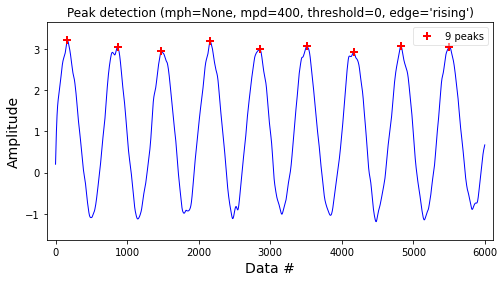

In [ ]:
maxs = detect_peaks(var, mpd=400, show=True)

Si quisiéramos detectar los valles, simplemente se debe incluir la instrucción *valley=True* en la función.

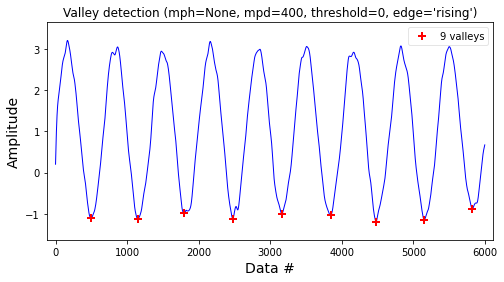

In [ ]:
mins = detect_peaks(var, mpd=400, valley=True, show=True)

Para más información sobre los ajustes finos de la función, consulta en la web de la librería [*Detecta*](https://pypi.org/project/detecta/).

Por el momento tenemos un listado de los puntos en los que se completan los ciclos, es decir, el índice del dato cuando cambia de una repetición a otra. Podemos ver los instantes que ha detectado.

In [ ]:
maxs

array([ 167,  867, 1479, 2162, 2857, 3510, 4167, 4827, 5503])

## Separar en repeticiones

A continuación, utilizaremos esos puntos de corte para ir metiendo en una lista cada repetición por separado con un bucle *for*, y después lo juntamos todo en un *dataframe* de *Pandas*.

In [ ]:
var_cortes = [] #lista vacía donde iremos incluyendo cada repetición

for corte in range(len(maxs)-1):
  var_cortes.append(var[maxs[corte]:maxs[corte+1]]) #coge el trozo de la variable desde un corte hasta el siguiente

dfVar_cortes = pd.DataFrame(var_cortes).T

dfVar_cortes

0         1         2  ...         5         6         7
0    3.206206  3.049284  2.945764  ...  3.060962  2.920530  3.073903
1    3.205909  3.048836  2.945684  ...  3.060801  2.920234  3.073377
2    3.204719  3.047732  2.945116  ...  3.060175  2.919606  3.072026
3    3.202680  3.045993  2.944115  ...  3.059144  2.918621  3.069857
4    3.199853  3.043634  2.942746  ...  3.057773  2.917258  3.066892
..        ...       ...       ...  ...       ...       ...       ...
695  3.041844       NaN       NaN  ...       NaN       NaN       NaN
696  3.044546       NaN       NaN  ...       NaN       NaN       NaN
697  3.046671       NaN       NaN  ...       NaN       NaN       NaN
698  3.048187       NaN       NaN  ...       NaN       NaN       NaN
699  3.049065       NaN       NaN  ...       NaN       NaN       NaN

[700 rows x 8 columns]

El *dataframe* resultante tiene en cada columna una repetición, y en filas los instantes temporales, que manienen la misma frecuencia de registro original.

Podemos representar gráficamente lo que hemos obtenido para ver todas las repeticiones juntas.

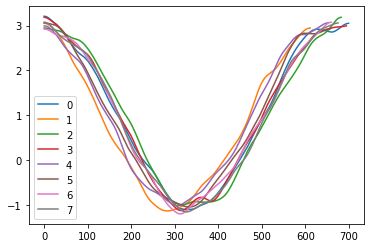

In [ ]:
dfVar_cortes.plot()

Una vez tenemos la señal dividida en repeticiones, podríamos por ejemplo normalizar el tiempo, realizar gráficas que representen la media $\pm$ desviación típica (*ensemble average*), etc.

# Realizar cortes con datos de señales de varios factores o dimensiones

Para simular un ejemplo parecido a un uso real, más complejo que el sencillo ejemplo anterior, crearemos unos datos de señales simuladas guardados en archivos. Se trata de datos que simulan un registro del ángulo de rodilla en ciclistas pedaleando a unas 90 rpm, registrados antes y después de cambiar la altura del sillín. De modo que tenemos registros con varios factores o dimensiones:
* 1) El participante.
* 2) El factor tiempo (pre/post).
* 3) El instante temporal dentro del registro (la variable tiempo en segundos). 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy.signal import butter, filtfilt
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

def crea_muestra_continua(num_suj=10, Fs=100.0, IDini=0, rango_offset = [-2.0, -0.5], rango_amp = [1.0, 2.2], rango_frec = [1.8, 2.4], rango_af=[0.0, 1.0], rango_duracion=[5.0, 5.1], amplific_ruido=[0.4, 0.7], fc_ruido=[7.0, 12.0]):
    sujeto=[]
    for suj in range(num_suj):
        
        a = np.random.uniform(rango_amp[0], rango_amp[1])
        of = np.random.uniform(rango_offset[0], rango_offset[1])
        f =  np.random.uniform(rango_frec[0], rango_frec[1])
        af =  np.deg2rad(np.random.uniform(rango_af[0], rango_af[1])) #lo pasa a radianes
        err = a * np.random.uniform(amplific_ruido[0], amplific_ruido[1])
        fc_err = np.random.uniform(fc_ruido[0], fc_ruido[1])
        duracion = np.random.uniform(rango_duracion[0], rango_duracion[1])
        
        Ts = 1./Fs #intervalo de tiempo entre datos en segundos
        t = np.arange(0, duracion, Ts)

        señal = np.array(of + a*np.sin(2*np.pi*f*t + af))
        
        #Crea un ruido aleatorio controlado
        pasadas = 2.0 #nº de pasadas del filtro adelante y atrás
        orden = 2
        Cf = (2**(1/pasadas)-1)**(1/(2*orden)) #correction factor. Para 2nd order = 0.802 
        Wn = 2*fc_err/Fs/Cf
        b1, a1 = butter(orden, Wn, btype = 'low')
        ruido = filtfilt(b1, a1, np.random.uniform(a-err, a+err, len(t)))
        
        
        #################################
        sujeto.append(pd.DataFrame(señal + ruido, columns=['value']).assign(**{'ID':'{0:02d}'.format(suj+IDini), 'time':np.arange(0, len(señal)/Fs, 1/Fs)}))
    return pd.concat(sujeto)

np.random.seed(12340) #fija la aleatoriedad para asegurarse la reproducibilidad

n=10 #número de participantes
duracion=10 #duración de cada registro en segundos
frec=200.0
Pre = crea_muestra_continua(n, Fs=frec, IDini=0, rango_offset = [25, 29], rango_amp = [40, 45], rango_frec = [1.48, 1.52], rango_af=[0, 30], amplific_ruido=[0.4, 0.7], fc_ruido=[3.0, 3.5], rango_duracion=[duracion, duracion]).assign(**{'tiempo':'pre'})
Post = crea_muestra_continua(n, Fs=frec, IDini=0, rango_offset = [22, 26], rango_amp = [36, 40], rango_frec = [1.48, 1.52], rango_af=[0, 30], amplific_ruido=[0.4, 0.7], fc_ruido=[3.0, 3.5], rango_duracion=[duracion, duracion]).assign(**{'tiempo':'post'})
dfTodosArchivos = pd.concat([Pre, Post]).reset_index()
dfTodosArchivos = dfTodosArchivos[['ID', 'tiempo', 'time', 'value']] #Reordena los factores



Siempre es conveniente visualizar los datos que tenemos en gráficas.

c:\Users\josel\mambaforge\envs\mienv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\josel\mambaforge\envs\mienv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\josel\mambaforge\envs\mienv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\josel\mambaforge\envs\mienv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

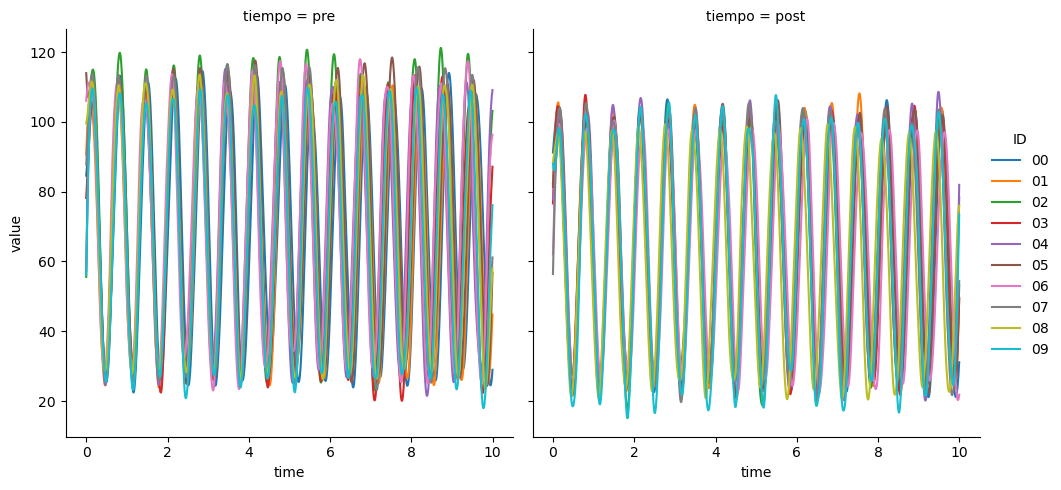

In [3]:
#Representa gráficamente los datos

sns.relplot(data=dfTodosArchivos, x='time', y='value',  col='tiempo', units='ID', estimator=None, hue='ID',  kind='line')

Una vez tenemos las señales en la variable *dfTodosArchivos*, procedemos a realizar los cortes. Para ello, en lugar de hacerlo como en el ejemplo anterior cortando de uno en uno y añadiéndo a una lista, lo que haremos será crear una nueva variable (columna) que guarde el instante temporal dentro de cada repetición dentro del ensayo global (que empiece a contar desde cero en cada una), que llamaremos *time_repe*, y otra que guarde el número de repetición en orden correlativo, que llamaremos *repe*. De esta manera realizamos el proceso a mucha más velocidad porque apenas tenemos que modificar ni crear variables.

In [ ]:
var_suj=[]
for n, gb in dfTodosArchivos.groupby(list(dfTodosArchivos.columns[:-2])):#['partID', 'tiempo']):#dfTodosArchivos.columns[:-1]):
  #print(n)
  cortes = detect_peaks(gb['value'], mpd=100, show=False)
  
  var_cortes = [] #lista vacía donde iremos incluyendo cada repetición
  for n_corte in range(len(cortes)-1):
    #print(cortes[n_corte], cortes[n_corte+1])
    var_cortes.append(gb.iloc[cortes[n_corte]:cortes[n_corte+1], :].assign(**{'repe':n_corte, 'time_repe':np.arange(0, (cortes[n_corte+1]-cortes[n_corte])/frec, 1/frec)})) #coge el trozo de la variable desde un corte hasta el siguiente

  var_suj.append(pd.concat(var_cortes))
  #dfVar_cortes = pd.concat(var_cortes)#pd.DataFrame(var_cortes).T
dfVar_cortes=pd.concat(var_suj)

Vamos a ver cómo ha quedado el *dataframe*. La variable *repe* es la que guarda el número de repetición dentro del ensayo, *time_repe* guarda el tiempo relativo a cada repetición, mientras que *time* sigue representando el tiempo del ensayo, por si hiciera falta.

In [ ]:
dfVar_cortes

partID tiempo   time       value  repe  time_repe
20022     00   post  0.110  103.609392     0      0.000
20023     00   post  0.115  103.586452     0      0.005
20024     00   post  0.120  103.466716     0      0.010
20025     00   post  0.125  103.250335     0      0.015
20026     00   post  0.130  102.938090     0      0.020
...      ...    ...    ...         ...   ...        ...
19886     09    pre  9.430  107.003187    13      0.655
19887     09    pre  9.435  107.658980    13      0.660
19888     09    pre  9.440  108.191112    13      0.665
19889     09    pre  9.445  108.593606    13      0.670
19890     09    pre  9.450  108.862402    13      0.675

[37446 rows x 6 columns]

Y lo representamos gráficamente separando en los distintos factores en filas y columnas.

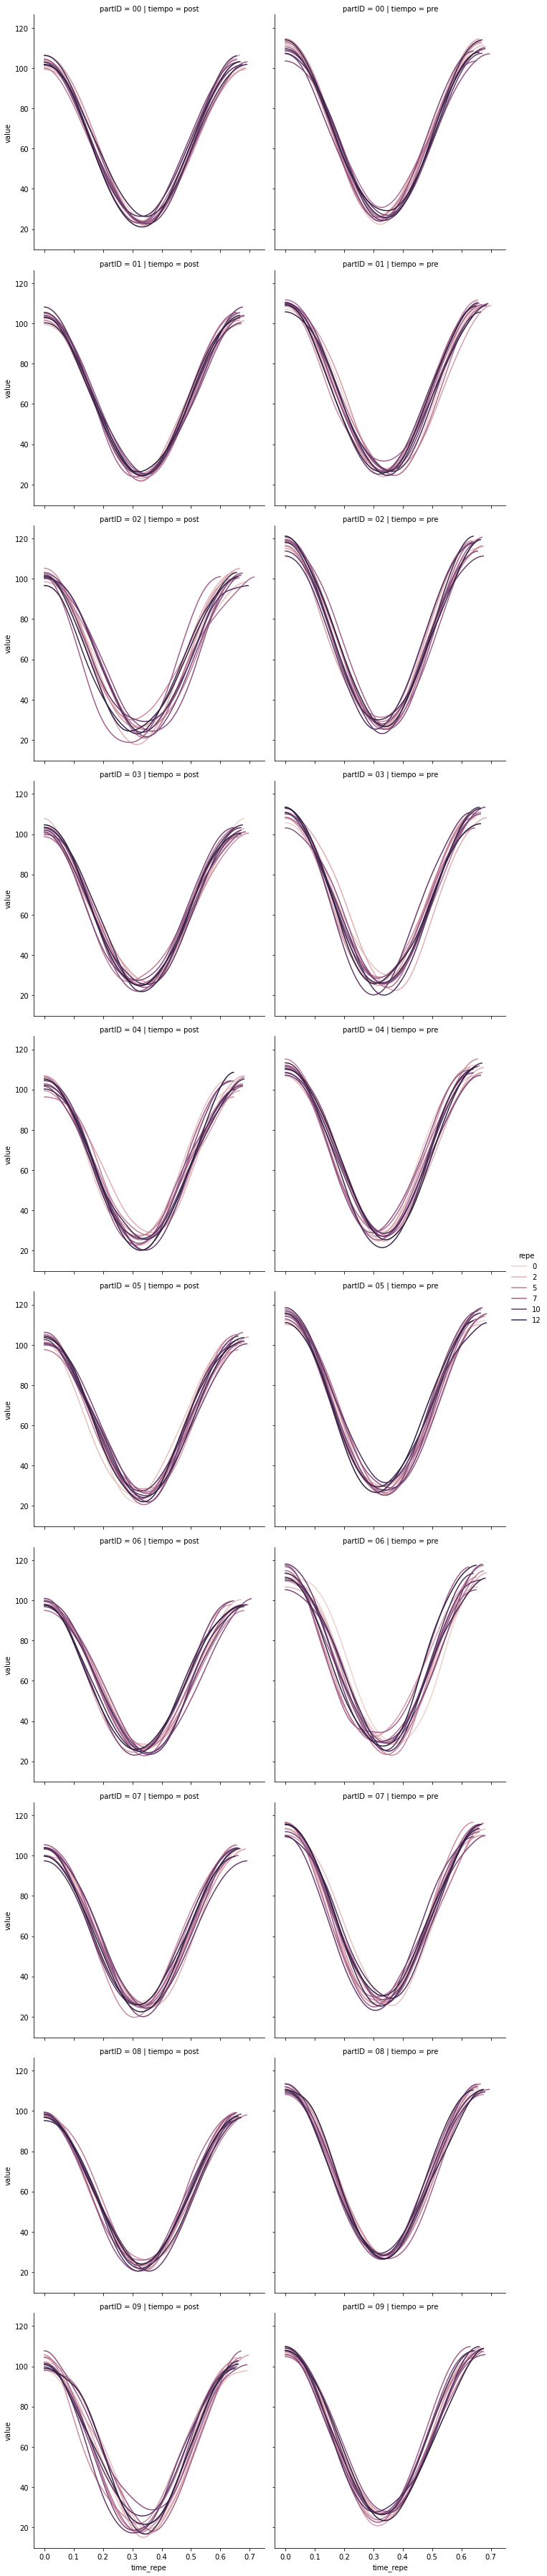

In [ ]:
sns.relplot(data=dfVar_cortes, x='time_repe', y='value',  row='partID', col='tiempo', units='repe', estimator=None, hue='repe',  kind='line')

# Ejemplo más complejo con varios factores y variables y eligiendo la variable de corte

En este caso vamos a utilizar datos de archivos de un caso real. Se trata de un registro cinemático de ciclistas pedaleando en dos condiciones distintas (que podemos considerar un factor intrasujeto con las condiciones pre y post). En los archivos tenemos como variables los ángulos de flexoextensión de cadera, rodilla y tobillo, y además el ángulo de la biela. Esta última variable es importante porque en casos como este, nos interesa hacer los cortes en función de una variable global, en este caso la posición del pedal (que recoge la variable del ángulo de la biela) y no en función de los máximos o mínimos de cada variable.

Los archivos que vamos a utilizar se encuentran en [esta carpeta](https://github.com/joselvira/BiomecanicaPython/tree/master/Datos/ArchivosPorFactoresBici). Puedes descargarlos en tu propio *Drive* para poder usarlos en este ejemplo desde Google Colab.

Lo siguiente es dar permiso a *Colab* para que acceda a los archivos de nuestro *Drive*. 

Por cierto, tienes otro notebook que explica cómo se gestionan los archivos y carpetas en [Lectura y escritura de archivos y carpetas](https://github.com/joselvira/BiomecanicaPython/blob/master/Notebooks/Lectura_escritura_archivos_carpetas.ipynb).

In [3]:
from google.colab import drive
from pathlib import Path #para gestión de archivos y carpetas

# Lo siguiente muestra un enlace para que otorguemos permiso para acceder a nuestro Drive
drive.mount('/googledrive', force_remount=True)

Mounted at /googledrive


Ahora probamos a cargar uno de los archivos para ver qué aspecto tienen. Recuerda que debes adaptar la variable *ruta_trabajo* a la carpeta de tu *Drive* donde hayas guardado los archivos.

In [4]:
ruta_trabajo = Path('/googledrive/My Drive/Colab Notebooks/ArchivosEjemplos/ArchivosPorFactoresBici') #adapta la ruta a tus necesidades
nombre_archivo = ruta_trabajo / 'Bici_s01_post.csv' #este es el nombre de uno de los archivos de la carpeta

dfDatos = pd.read_csv(nombre_archivo)

dfDatos

partID tiempo   time    AngBiela   cadera   rodilla  tobillo
0          1   post  0.000  -69.317007  66.8779   41.4449  21.3638
1          1   post  0.005  -66.416695  65.8195   39.9702  20.5326
2          1   post  0.010  -63.427001  64.7513   38.4799  19.6270
3          1   post  0.015  -60.372563  63.6776   36.9949  18.6558
4          1   post  0.020  -57.276184  62.6151   35.5349  17.6282
...      ...    ...    ...         ...      ...       ...      ...
1194       1   post  5.970  166.617273  93.0980  107.1120  14.2697
1195       1   post  5.975  169.053489  93.5121  106.8850  14.3941
1196       1   post  5.980  171.470225  93.9091  106.5890  14.5180
1197       1   post  5.985  173.868627  94.2881  106.2240  14.6405
1198       1   post  5.990  176.250412  94.6481  105.7910  14.7613

[1199 rows x 7 columns]

Y la mostramos en una gráfica.

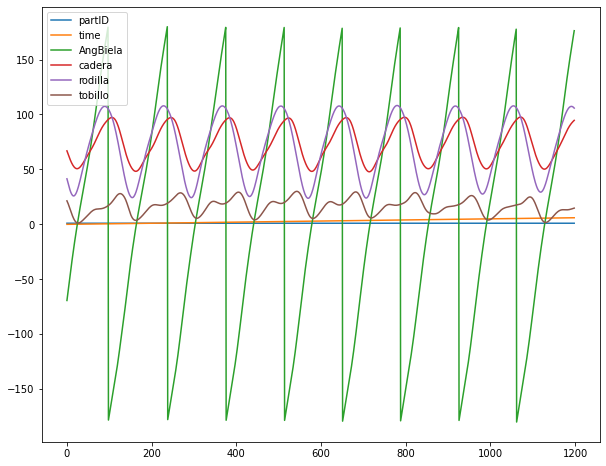

In [7]:
dfDatos.plot(figsize=(10,8))

Se puede ver que el archivo contiene las variables de factores *partID*, que corresponde al número del participante, el factor *tiempo* que puede ser *pre* o *post*, y las variables del ángulo de la biela, de la *cadera*, *rodilla* y *tobillo*.

La frecuencia de registro son 200 Hz porque entre dato y dato pasan 0.005 s, el registro dura 6 s y realiza unas 8 repeticiones.

A la hora de realizar cortes según repeticiones, fíjate en que al tener distintas variables, si cogiéramos como criterio de corte el valor máximo o mínimo de cada variable sería confuso, porque no van del todo sincronizadas. Por eso necesitamos una variable común que sirva para marcar el corte de cada repetición. En este caso es el ángulo de la biela, y vamos a considerar que las repeticiones empiezan cuando el ángulo llega a su máximo, en este caso 180º, que corresponde a la posición del pedal más alta. 

Vamos a probar cómo deberían ser los parámetros de la función *detect_peaks* para que encuentre correctamente los máximos locales. La frecuencia de pedaleo son unos 90 rmp (1.5 Hz) y la frecuencia de registro son 200 Hz, por lo que cada ciclo o repetición tiene 200/1.5 datos, es decir, 133.33 datos. Para asegurar, ponemos 100 en el parámetro *mpd* (mínima distancia entre picos en número de datos).

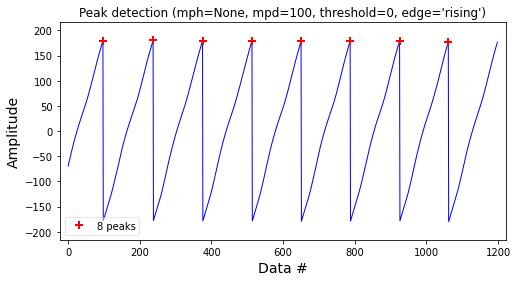

array([  97,  237,  375,  513,  650,  787,  925, 1061])

In [10]:
#Instala la librería detecta (Marcos Duarte)
!pip install detecta

from detecta import detect_peaks

detect_peaks(dfDatos['AngBiela'], mpd=100, show=True)


A continuación procedemos a cargar todos los archivos en la memoria. Lo haremos metiendo todos los archivos en una sola variable para facilitar los tratamientos posteriores. Iremos cargando archivo por archivo, les incluiremos columnas con identificadores de los factores que correspondan, los guardaremos en una lista y al final los concatenamos. Para terminar, colocaremos los datos en formato vertical (*long*), apilando los datos de los archivos unos sobre otros.
Recuerda que en el notebook [Lectura y escritura de archivos y carpetas](https://github.com/joselvira/BiomecanicaPython/blob/master/Notebooks/Lectura_escritura_archivos_carpetas.ipynb) puedes encontrar una explicación más detallada de cómo y por qué se hace todo esto.

In [11]:
#Mete en una variable todas las rutas de los archivos que queremos cargar
lista_archivos = list(ruta_trabajo.glob('**/*.csv')) #crea una lista con todos los archivos de la carpeta y subcarpetas
lista_archivos.sort() #ordena los resultados por orden alfabético
lista_archivos

[PosixPath('/googledrive/My Drive/Colab Notebooks/ArchivosEjemplos/ArchivosPorFactoresBici/Bici_s01_post.csv'),
 PosixPath('/googledrive/My Drive/Colab Notebooks/ArchivosEjemplos/ArchivosPorFactoresBici/Bici_s01_pre.csv'),
 PosixPath('/googledrive/My Drive/Colab Notebooks/ArchivosEjemplos/ArchivosPorFactoresBici/Bici_s02_post.csv'),
 PosixPath('/googledrive/My Drive/Colab Notebooks/ArchivosEjemplos/ArchivosPorFactoresBici/Bici_s02_pre.csv'),
 PosixPath('/googledrive/My Drive/Colab Notebooks/ArchivosEjemplos/ArchivosPorFactoresBici/Bici_s03_post.csv'),
 PosixPath('/googledrive/My Drive/Colab Notebooks/ArchivosEjemplos/ArchivosPorFactoresBici/Bici_s03_pre.csv'),
 PosixPath('/googledrive/My Drive/Colab Notebooks/ArchivosEjemplos/ArchivosPorFactoresBici/Bici_s04_post.csv'),
 PosixPath('/googledrive/My Drive/Colab Notebooks/ArchivosEjemplos/ArchivosPorFactoresBici/Bici_s04_pre.csv'),
 PosixPath('/googledrive/My Drive/Colab Notebooks/ArchivosEjemplos/ArchivosPorFactoresBici/Bici_s05_post.csv

In [12]:
import time
dfTodosArchivos = [] #guarda los dataframes que va leyendo en formato lista y al final los concatena
errores_archivos = [] #guarda los nombres de archivo que no se pueden abrir y su error
num_archivos_procesados = 0
tiempo_todos = time.time() #inicia el contador de tiempo
for nf, nombre_archivo in enumerate(lista_archivos[:]):
    try:
        tiempo_archivo = time.time() #inicia el contador de tiempo del archivo
        
        print('Cargando archivo nº {0}: {1:s}'.format(nf, nombre_archivo.name))
        Datos = pd.read_csv(nombre_archivo)

        #asigna etiquetas con los nombres de los factores
        SID=nombre_archivo.stem.split('_')[1]
        tiempo=nombre_archivo.stem.split('_')[2]                   
        
        #Carga el dataframe comun y asigna nombres a las columnas según el factor
        dfTodosArchivos.append(Datos.assign(**{'partID':SID, 'tiempo':tiempo}).reset_index(drop=True))
            
    except Exception as err: #Si falla anota un error y continua
        print('\nATENCIÓN. No se ha podido procesar {0}, {1}, {2}'.format(nombre_archivo.parent.name, nombre_archivo.name, err), '\n')
        errores_archivos.append(nombre_archivo.parent.name+' '+nombre_archivo.name+' '+ str(err))
        continue

    #Termina el archivo
    print('{0} filas y {1} columnas'.format(dfTodosArchivos[-1].shape[0], dfTodosArchivos[-1].shape[1]))
    print('Tiempo {0:.3f} s \n'.format(time.time()-tiempo_archivo))
    num_archivos_procesados+=1

print('Cargados {0:d} archivos en {1:.3f} s \n'.format(num_archivos_procesados, time.time()-tiempo_todos))
#Si no ha podido cargar algún archivo, lo indica
if len(errores_archivos) > 0:
    print('\nATENCIÓN. No se ha podido cargar:')
    for x in range(len(errores_archivos)):
        print(errores_archivos[x])

#concatena en un mismo dataframe todos los dataframes individuales de la lista
dfTodosArchivos = pd.concat(dfTodosArchivos)


#Coloca los factores en formato long
dfTodosArchivos = pd.melt(dfTodosArchivos, id_vars=['partID', 'tiempo', 'AngBiela', 'time'], var_name='variable', value_name='value')
#dfTodosArchivos = dfTodosArchivos.set_index(['partID', 'grupo', 'tiempo', 'time'])


Cargando archivo nº 0: Bici_s01_post.csv
1199 filas y 7 columnas
Tiempo 0.009 s 

Cargando archivo nº 1: Bici_s01_pre.csv
1199 filas y 7 columnas
Tiempo 0.269 s 

Cargando archivo nº 2: Bici_s02_post.csv
1199 filas y 7 columnas
Tiempo 0.217 s 

Cargando archivo nº 3: Bici_s02_pre.csv
1199 filas y 7 columnas
Tiempo 0.299 s 

Cargando archivo nº 4: Bici_s03_post.csv
1199 filas y 7 columnas
Tiempo 0.322 s 

Cargando archivo nº 5: Bici_s03_pre.csv
1199 filas y 7 columnas
Tiempo 0.213 s 

Cargando archivo nº 6: Bici_s04_post.csv
1199 filas y 7 columnas
Tiempo 0.292 s 

Cargando archivo nº 7: Bici_s04_pre.csv
1199 filas y 7 columnas
Tiempo 0.322 s 

Cargando archivo nº 8: Bici_s05_post.csv
1199 filas y 7 columnas
Tiempo 0.318 s 

Cargando archivo nº 9: Bici_s05_pre.csv
1199 filas y 7 columnas
Tiempo 0.360 s 

Cargando archivo nº 10: Bici_s06_post.csv
1199 filas y 7 columnas
Tiempo 0.292 s 

Cargando archivo nº 11: Bici_s06_pre.csv
1199 filas y 7 columnas
Tiempo 0.431 s 

Cargando archivo nº 

Mostramos la variable que hemos creado. Fíjate en que hemos dejado el *dataframe* con formato *long* (los archivos se apilan en vertical). Hemos dejado la variable *AngBiela* como un factor, puesto que lo usaremos para hacer los cortes en repeticiones.

In [13]:
dfTodosArchivos

partID tiempo   AngBiela   time variable     value
0        s01   post -69.317007  0.000   cadera  66.87790
1        s01   post -66.416695  0.005   cadera  65.81950
2        s01   post -63.427001  0.010   cadera  64.75130
3        s01   post -60.372563  0.015   cadera  63.67760
4        s01   post -57.276184  0.020   cadera  62.61510
...      ...    ...        ...    ...      ...       ...
71935    s10    pre  82.487015  5.970  tobillo   8.76749
71936    s10    pre  85.935648  5.975  tobillo   8.88284
71937    s10    pre  89.462776  5.980  tobillo   9.03665
71938    s10    pre  93.063816  5.985  tobillo   9.23393
71939    s10    pre  96.729600  5.990  tobillo   9.47879

[71940 rows x 6 columns]

Y lo mostramos gráficamente con la librería *seaborn* en una sola línea de código.

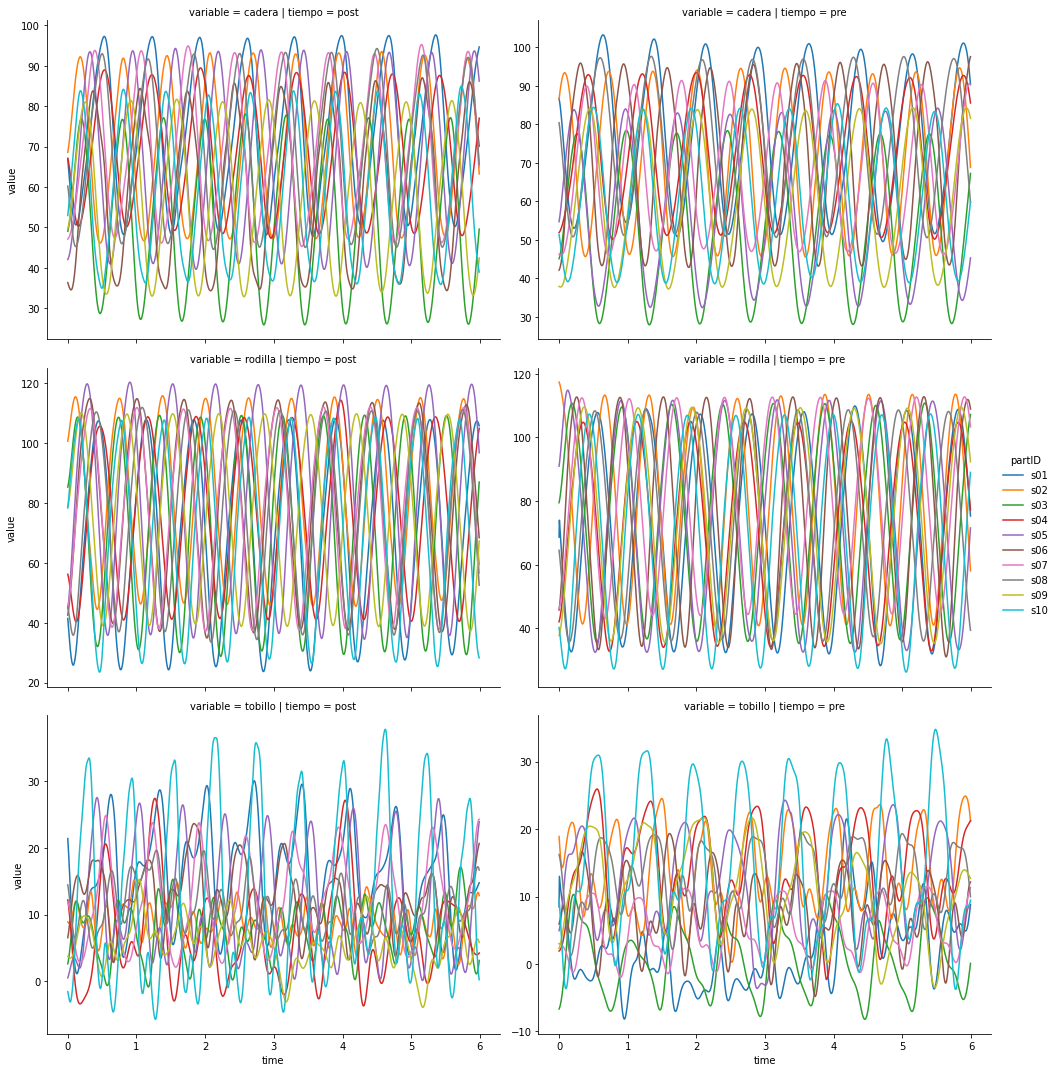

In [14]:
sns.relplot(data=dfTodosArchivos, x='time', y='value',  col='tiempo', row='variable', units='partID', estimator=None, hue='partID',  kind='line', aspect=1.4, facet_kws={'sharey': False})

Lo que haremos ahora es realizar los cortes. Vamos a utilizar la misma técnica mostrada en la sección anterior, pero haciéndolo un poco más sofisticado. En la siguiente celda puedes ver una función que encapsula el procedimiento para hacerlo más genérico y aplicable a más situaciones. Se le pueden pasar argumentos para indicar qué variables son factores, cuál es la variable de referencia para hacer los cortes, y cuáles son las variables en sí a cortar. También se le puede pasar directamente la función con la que hacer los cortes y si tiene algún argumento especial. Carga la función y después la probaremos en distintas situaciones.

## Función para cortar por factores

También puedes encontrar una versión independiente de esta función en la carpeta de [funciones](https://github.com/joselvira/BiomecanicaPython/tree/master/Funciones) de este mismo *github*.

In [15]:
def corta_repes(dfData, frec=None, col_factores=[], col_referencia='value', col_variables=[], col_tiempo='time', func_cortes=None, **args_func_cortes):
    """
    Función para realizar cortes en señales cíclicas contínuas
    
    Parámetros
    ----------
    dfData : Pandas dataframe
        Contiene los datos continuos
        Puede estar en formato 'long' o 'tidy'
        Puede contener distinto número de factores
        
    frec : float
        frecuencia de muestreo de la señal.
        
    col_tiempo : string
        Nombre de la columna que contiene la variable temporal
        
    col_factores : list
        Listado de nombres de las columnas que contienen los factores
        
    col_referencia : string
        Nombre de la columna que contiene la variable a utilizar de referencia 
        para los cortes
        
    col_variables : streng o list
        Nombres de las columnas que contienen las variables a cortar. Puede ser
        una única columna o una lista con los combres de varias.
        
    descarta_rep_ini: int
        Número de repeticiones que descarta desde el inicio.
        
    descarta_rep_fin: int
        Número de repeticiones que descarta desde el final.
        No funciona si se especifica num_repes.
        
    num_repes: int
        Número de repeticiones a considerar desde las descartadas al inicio.
    
    func_cortes : nombre de función
        Nombre de la función a emplear para hacer los cortes. La función debe 
        admitir un array 1D y devolver una lista también 1D con los índices de 
        los cortes
        
    args_func_cortes : dictionary
        Diccionario con los argumentos a pasar a la función que realiza los 
        cortes
        
    
    Devuelve
    -------
    dfVar_cortes : Pandas dataframe
        dataframe con los datos originales con dos columnsa añadidas:
            repe : contiene el número de la repetición
            time_repe : contiene el tiempo local de cada repetición
            
        
    Ejemplos
    --------
    >>> df_cortes = corta_repes(dfTodosArchivos, func_cortes=detect_peaks,  
                    col_factores=['partID', 'tiempo'], col_referencia='value', 
                    col_variables=['value'], descarta_rep_ini=11, num_repes=4, 
                    descarta_rep_fin=2, **dict(mpd=100, show=False))
    
    >>> df_cortes = corta_repes(dfTodosArchivos, func_cortes=detect_peaks,  
                    col_factores=['partID', 'tiempo'], col_referencia='value',
                    col_variables=['value'], descarta_rep_ini=10, 
                    descarta_rep_fin=2, **dict(mpd=100, show=False))
    
    """
    if not isinstance(col_variables, list):
        col_variables= [col_variables]
        
    if func_cortes==None:
        raise Exception('Debes especificar una función para buscar cortes')
        #func=detect_peaks
    
    if col_factores==[]:
        col_factores = list(dfData.columns[:-2])
    
    if frec==None:
        frec = 1/dfData.iloc[1, dfData.columns.get_loc(col_tiempo)]
        
    var_bloque=[] #lista vacía donde irá guardando cada ensayo completo
    for n, gb in dfData.groupby(col_factores):
      #Busca los cortes
      cortes = func_cortes(gb[col_referencia], **args_func_cortes)
      
      #Divide en los cortes encontrados
      var_cortes = [] #lista vacía donde iremos incluyendo cada repetición
      for n_corte in range(len(cortes)-1):
          var_cortes.append(gb.iloc[cortes[n_corte]:cortes[n_corte+1], :].assign(**{'repe':n_corte, 'time_repe':np.arange(0, (cortes[n_corte+1]-cortes[n_corte])/frec, 1/frec)[:(cortes[n_corte+1]-cortes[n_corte])]})) #coge el trozo de la variable desde un corte hasta el siguiente
        
      if var_cortes!=[]:
          var_bloque.append(pd.concat(var_cortes))
      
    dfVar_cortes = pd.concat(var_bloque)

    #Reordena las columnas
    if [col_referencia] != col_variables:
        columnas = col_factores+[col_tiempo, 'repe', 'time_repe', col_referencia]+ col_variables #reordena factores
    else:
        columnas = col_factores+[col_tiempo, 'repe', 'time_repe', col_referencia] #reordena factores
    dfVar_cortes = dfVar_cortes[columnas]
    
    return dfVar_cortes


Una vez hemos cargado la función, podemos usarla para hacer los cortes.

La función toma como argumento el nombre de otra función externa que será la que vaya cortando cada bloque de datos (los datos de cada ensayo guardados originalmente en cada archivo). Es importante importar esa función antes de usarla.

En este ejemplo, a la función le pasamos el argumento ***col_factores*** con los nombres de columnas con los factores o dimensiones: 'partID' (con los identificadores de los participantes), 'tiempo' (con los valores *pre* y *post*) y 'variable' (con los nombres de las variables); también se pasa el argumento ***col_referencia*** con el nombre de la variable que se usa para hacer los cortes ('AngBiela'); como argumento ***func_cortes*** el nombre *detect_peaks* para indicar que vamos a usar esa función para detectar los eventos a partir de los cuales se harán los cortes;y por último se pasan como una variable diccionario los argumentos de la función que busca los eventos.

In [17]:
from detecta import detect_peaks
df_cortes = corta_repes(dfTodosArchivos, col_factores=['partID', 'tiempo', 'variable'], col_referencia='AngBiela', col_variables='value', func_cortes=detect_peaks, **dict(mpd=100))
df_cortes


partID tiempo variable   time  repe  time_repe    AngBiela    value
97       s01   post   cadera  0.485     0      0.000  179.492207  95.2438
98       s01   post   cadera  0.490     0      0.005 -178.160080  95.6065
99       s01   post   cadera  0.495     0      0.010 -175.821840  95.9398
100      s01   post   cadera  0.500     0      0.015 -173.492766  96.2416
101      s01   post   cadera  0.505     0      0.020 -171.171141  96.5156
...      ...    ...      ...    ...   ...        ...         ...      ...
71820    s10    pre  tobillo  5.395     6      0.690  169.844744  25.8511
71821    s10    pre  tobillo  5.400     6      0.695  171.996773  26.7701
71822    s10    pre  tobillo  5.405     6      0.700  174.072027  27.6606
71823    s10    pre  tobillo  5.410     6      0.705  176.077952  28.5167
71824    s10    pre  tobillo  5.415     6      0.710  178.022571  29.3339

[64341 rows x 8 columns]

Vemos gráficamente los cortes que ha hecho para cada participante y condición temporal. En este caso, se pide que ponga cada participante en una gráfica, y que marque con distinto trazo (*style*) las repeticiones de cada factor tiempo.

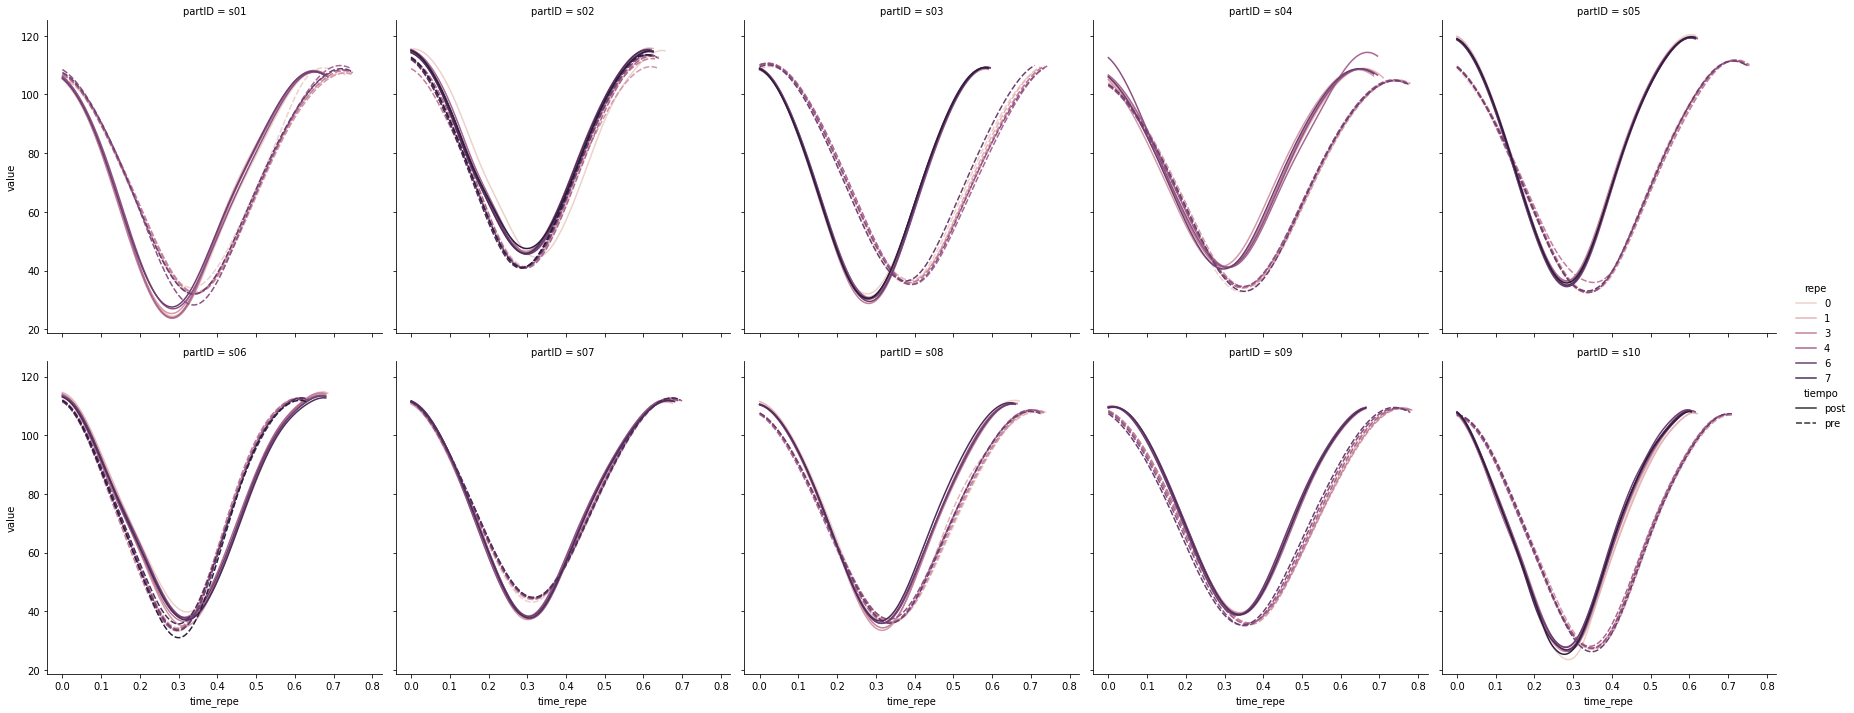

In [18]:
sns.relplot(data=df_cortes.query('variable=="rodilla"'), x='time_repe', y='value', col='partID', col_wrap=5, style='tiempo', units='repe', estimator=None, hue='repe',  kind='line')


En caso de necesitarlo, también podemos usar la misma función para que haga los cortes en función de los máximos de cada variable independientemente. Lo podemos hacer pasando como argumento ***col_referencia*** el propio nombre de las variables. Fíjate en que ahora las repeticiones empiezan en los máximos y mínimos de la misma variable usada para los cortes.

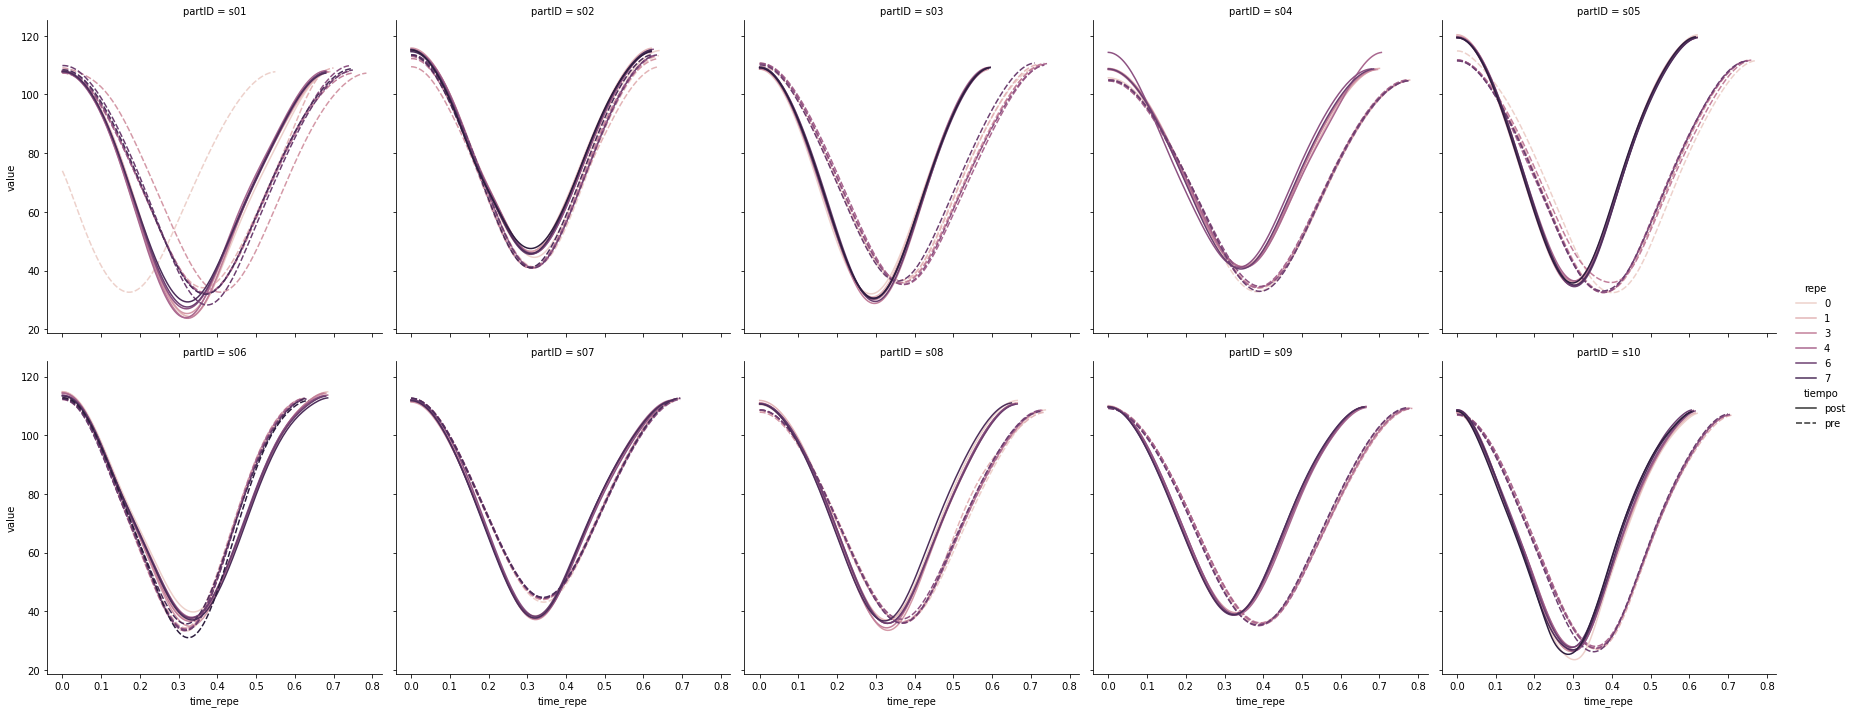

In [ ]:
df_cortes = corta_repes(dfTodosArchivos, col_factores=['partID', 'tiempo', 'variable'], col_referencia='value', col_variables=['value'], func_cortes=detect_peaks, **dict(mpd=100))
sns.relplot(data=df_cortes.query('variable=="rodilla"'), x='time_repe', y='value', col='partID', col_wrap=5, style='tiempo', units='repe', estimator=None, hue='repe',  kind='line')


También podríamos realizar los cortes a partir de los mínimos del ángulo de la biela, por ejemplo. Para ello incluimos el *valley=True* entre los argumentos de la función. En este caso no cambiaría mucho entre el mínimo y el máximo de la biela, porque cambia inmediatamente de uno a otro, pero podemos probar con los mínimos de las propias variables para ver la diferencia.

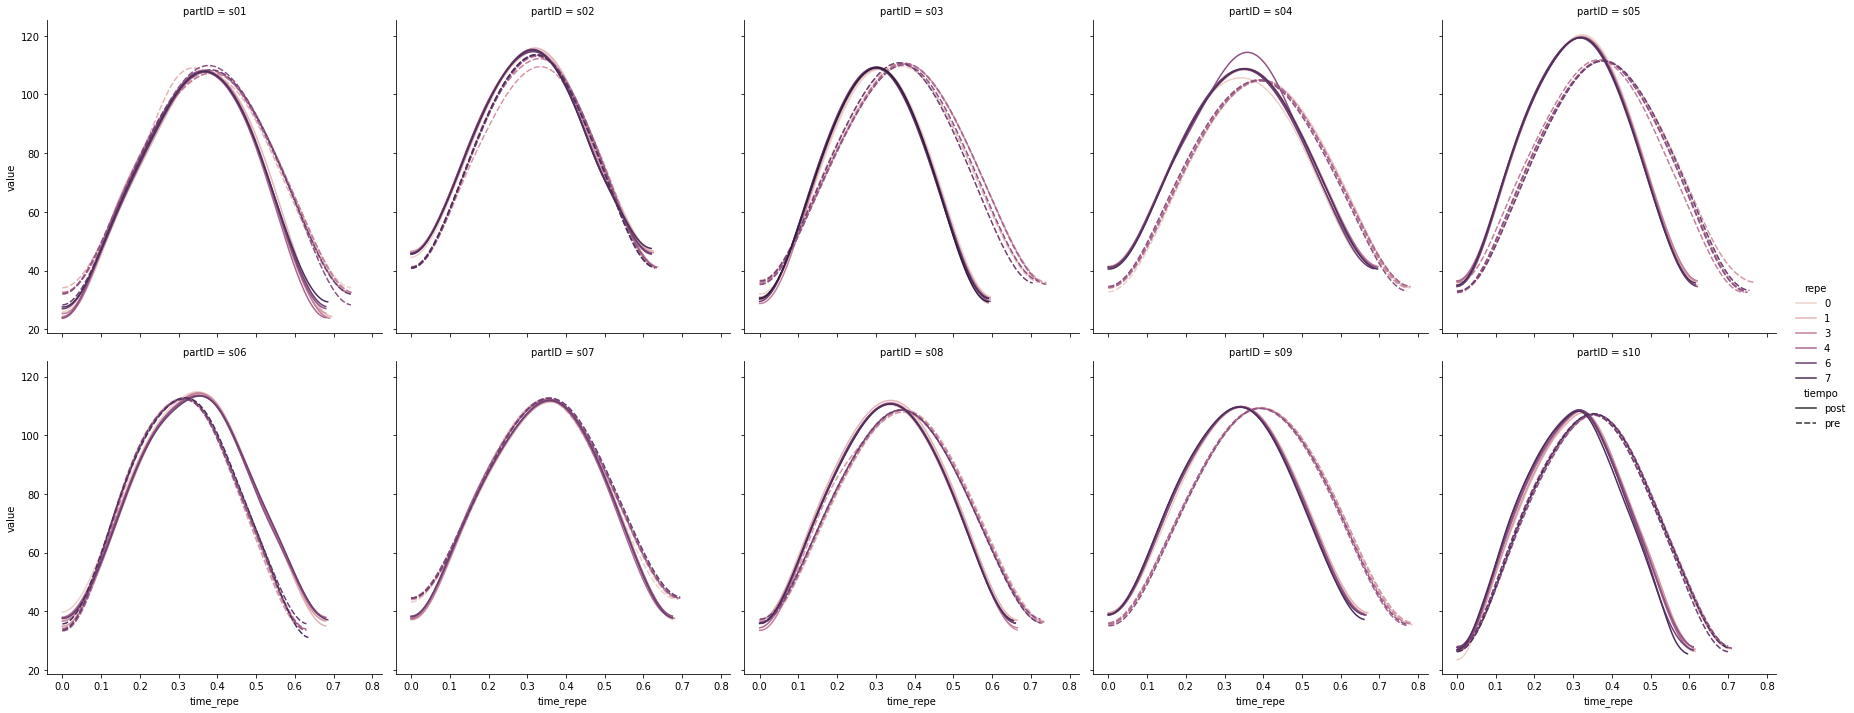

In [ ]:
df_cortes = corta_repes(dfTodosArchivos, col_factores=['partID', 'tiempo', 'variable'], col_referencia='value', col_variables='value', func_cortes=detect_peaks, **dict(mpd=100, valley=True))
sns.relplot(data=df_cortes.query('variable=="rodilla"'), x='time_repe', y='value', col='partID', col_wrap=5, style='tiempo', units='repe', estimator=None, hue='repe',  kind='line')

Otra cosa interesante, es que al poder pasar todos los argumentos de la función que usamos para realizar los cortes, podemos pedirte a la función *detect_peaks* que muestre una gráfica con cada análisis de cortes que hace. Para que no ocupe mucho espacio en este *notebook*, lo probamos con solo una parte del *dataframe* (el ángulo de cadera pre).

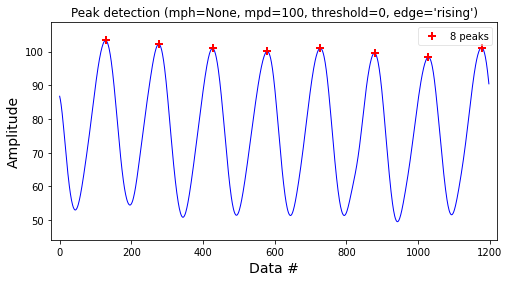

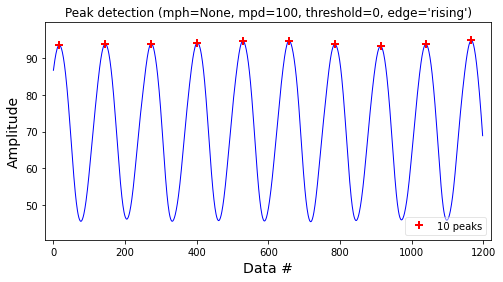

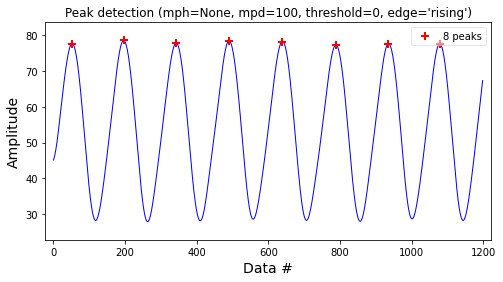

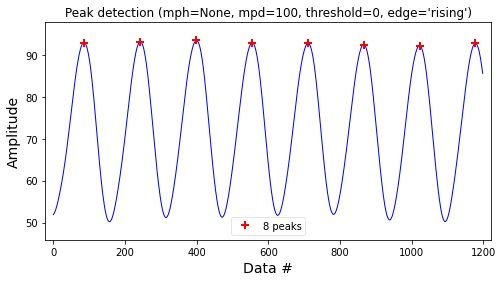

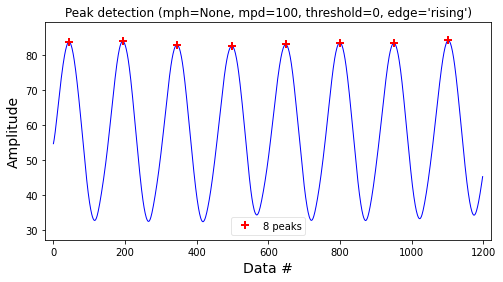

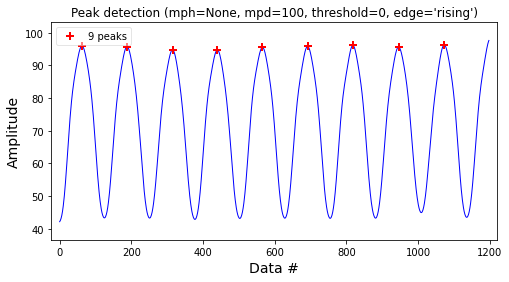

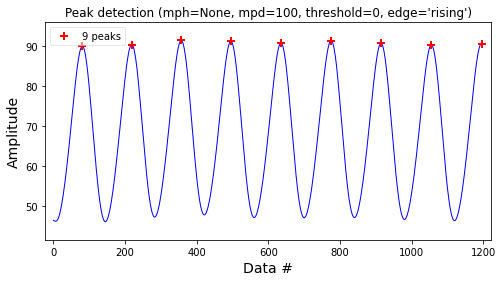

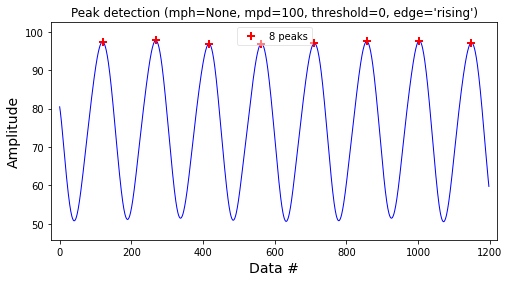

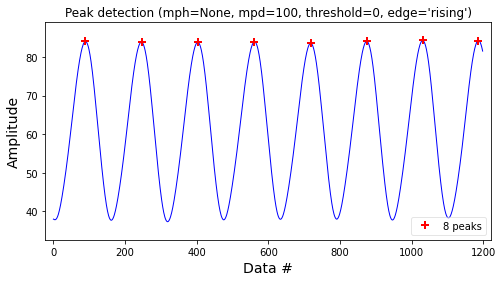

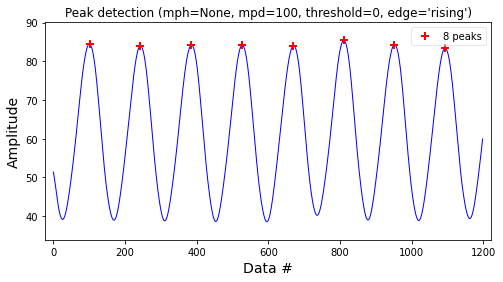

In [ ]:
df_cortes = corta_repes(dfTodosArchivos.query('variable=="cadera" & tiempo=="pre"'), col_factores=['partID', 'tiempo', 'variable'], col_referencia='value', col_variables='value', func_cortes=detect_peaks, **dict(mpd=100, show=True))

## Otras funciones de corte

También se pueden pasar otras funciones para detectar cortes, como la probada anteriormente *find_peaks* de la librería *scipy*, o la función *detect_onset*, también del módulo *detecta*, que sirve para encontrar cuándo la señal pasa por un umbral determinado (hacia arriba o hacia abajo).

Parahacer una prueba, vamos a intentar detectar las repeticiones cuando **el ángulo de la biela pasa por el cero**, y lo haremos con la función *detect_onset*, también incluida en la librería [*Detecta*](https://pypi.org/project/detecta/) creada por Marcos Duarte.

Una cosa importante es que antes de llamar a la función que samos para buscar los cortes, tenemos que importarla. Y una segunda cosa importante que tenemos que tener en cuenta es que esta función *detect_onset* devuelve pares de valores de corte (uno cuando la señal supera el umbral fijado hacia arriba, y otro cuando desciende por debajo). Fíjate en el siguiente ejemplo con uno de los ensayos.

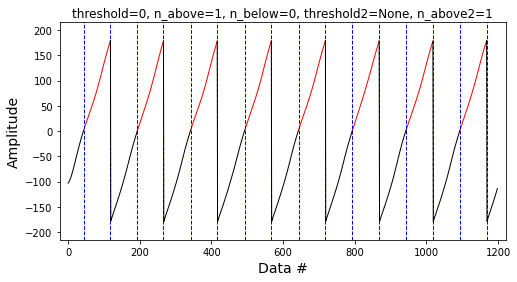

array([[  43,  118],
       [ 193,  266],
       [ 342,  416],
       [ 493,  567],
       [ 643,  718],
       [ 793,  868],
       [ 943, 1018],
       [1093, 1168]])

In [19]:
from detecta import detect_onset
df = dfTodosArchivos.query('partID=="s01" & tiempo=="pre" & variable=="rodilla"')['AngBiela']
detect_onset(df, threshold=0.0, show=True)

En la gráfica se ve en rojo los tramos en los que la señal está por encima del umbral que hemos fijado, y el *array* que devuelve tiene listas con un par de datos cada una, que corresponden al índice en el que la señal pasa por encima del umbral y cuando pasa hacia abajo.

Como nuestra función de detectar cortes (*corta_repes*) espera solamente un listado con un solo valor por corte, vamos a crear una función intermedia que llame a la función *detect_onset*, que luego se quede sólo con el corte de subida y devuelva el listado con esos valores de corte.

In [21]:
def detect_onset_aux(dfData, **args_func_cortes):
  cortes = detect_onset(dfData, **args_func_cortes)
  cortes = cortes[:,0] #se queda con el primer dato de cada par de datos.
  return cortes

Esta nueva función sí podemos llamarla para que nos devuelva solamente los cortes hacia arriba. La parte final con el argumento *args_func_cortes* es para que podamos incluir el número de parámetros de la función original que queramos y no estemos obligados a darles un valor a todos.

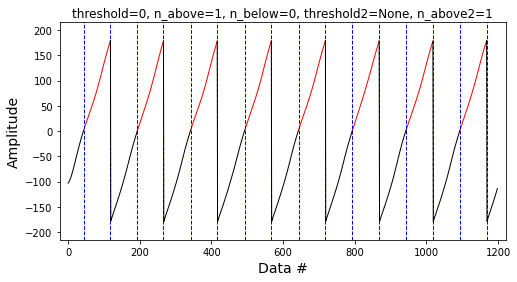

array([  43,  193,  342,  493,  643,  793,  943, 1093])

In [22]:
df = dfTodosArchivos.query('partID=="s01" & tiempo=="pre" & variable=="rodilla"')['AngBiela']
detect_onset_aux(df,  **dict(threshold=0.0, show=True))

Ahora sí devuelve un solo valor por cada corte encontrado. Con esto ya podemos llamar a nuestra función para crear cortes pasando el parámetro *func_cortes= detect_onset_aux*.

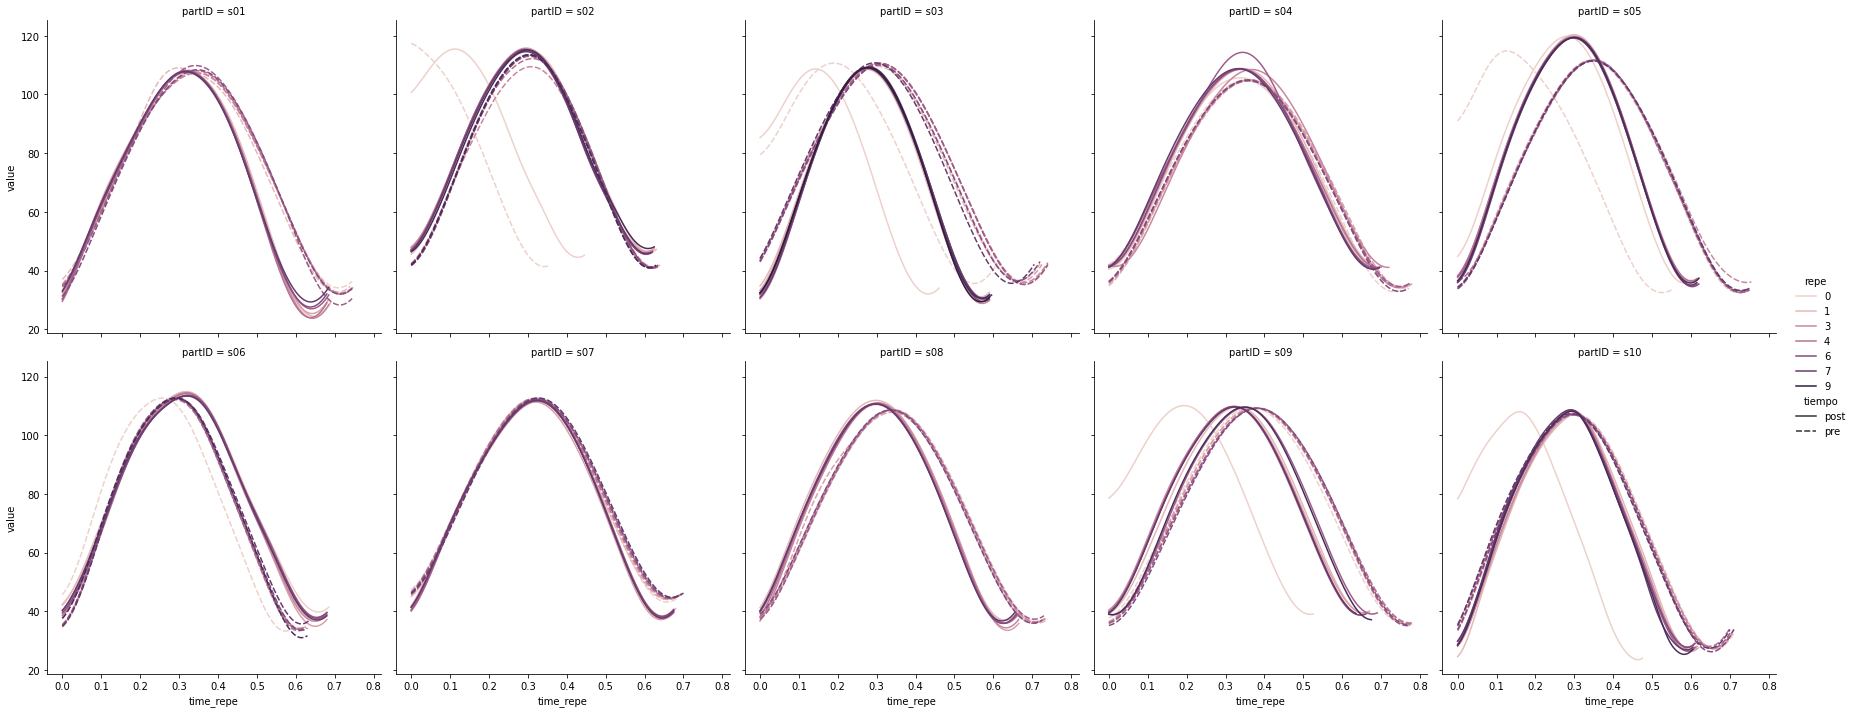

In [23]:
from detecta import detect_onset
df_cortes = corta_repes(dfTodosArchivos, func_cortes= detect_onset_aux, col_factores=['partID', 'tiempo', 'variable'], col_referencia='AngBiela', col_variables='value', **dict(threshold=0.0, show=False))
sns.relplot(data=df_cortes.query('variable=="rodilla"'), x='time_repe', y='value', col='partID', col_wrap=5, style='tiempo', units='repe', estimator=None, hue='repe',  kind='line')

El problema de utilizar la función para detectar *onsets* es que puede pasar que empieze o termine con una repetición a medias, por lo que interesa descartar el primer y último cortes. En la gráfica anterior se ven algunas repeticiones que están desfasadas (se ven en color más claro), corresponden a estos casos en los que el registro empieza con la repetición ya empezada y lo considera como el corte inicial. Vamos a perfeccionar la función *detect_onset_aux* para que no devuelva el primer corte que encuentra.

In [24]:
def detect_onset_aux(dfData, **args_func_cortes):
  cortes = detect_onset(dfData, **args_func_cortes)
  cortes = cortes[:,0] #se queda con el primer dato de cada par de datos.
  return cortes[1:]

Y volvemos a probar. Ahora se ve que ya no aparecen esas repeticiones desfasadas.

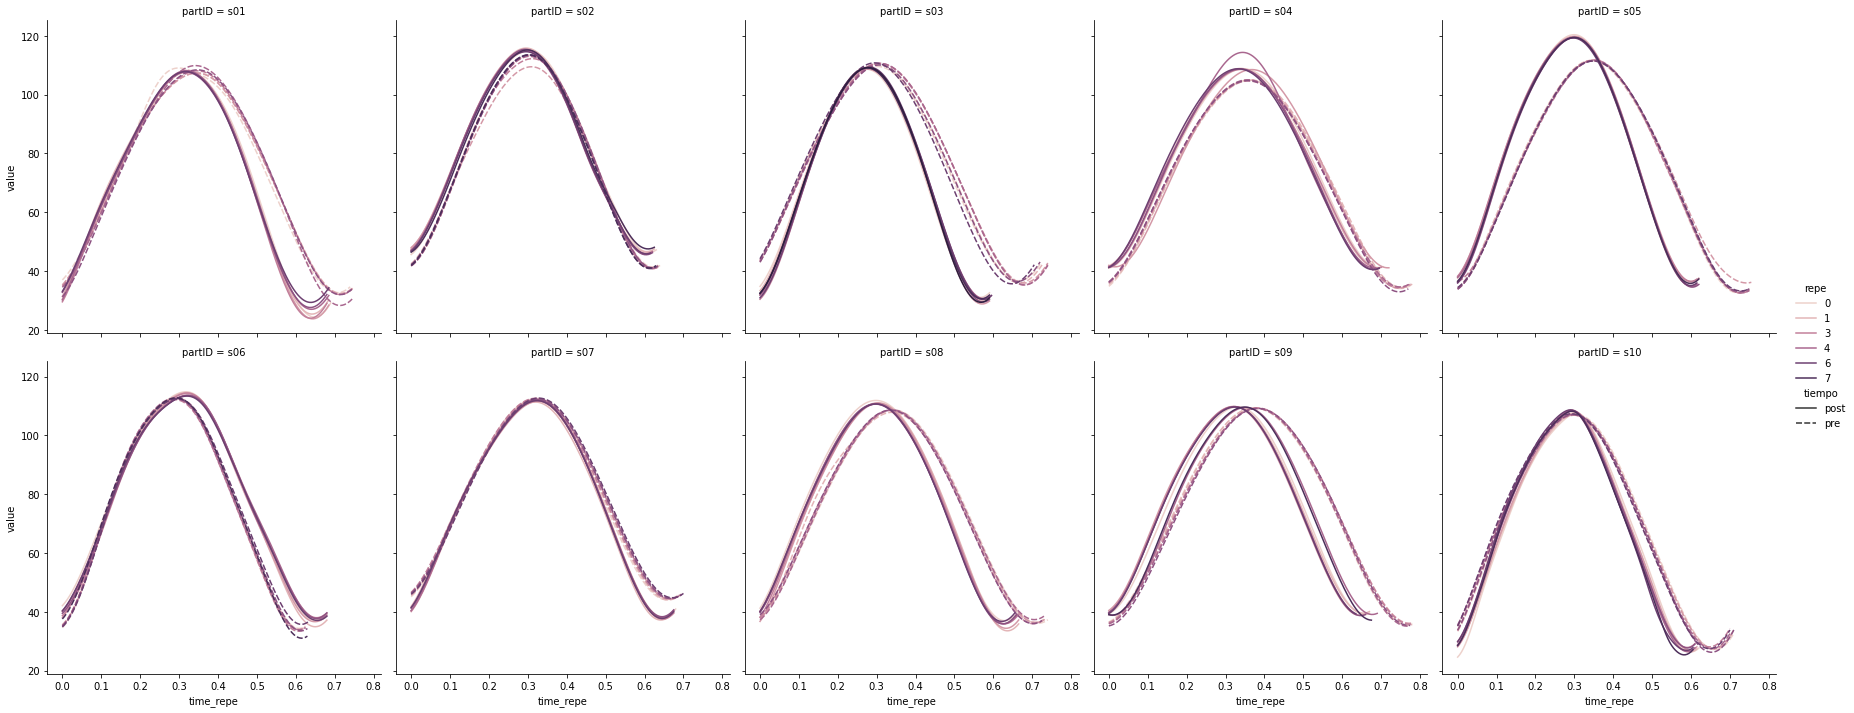

In [25]:
df_cortes = corta_repes(dfTodosArchivos, func_cortes= detect_onset_aux, col_factores=['partID', 'tiempo', 'variable'], col_referencia='AngBiela', col_variables='value', **dict(threshold=0.0, show=False))
sns.relplot(data=df_cortes.query('variable=="rodilla"'), x='time_repe', y='value', col='partID', col_wrap=5, style='tiempo', units='repe', estimator=None, hue='repe',  kind='line')